## If you are running in collab, run the following cell, if not skip to the next one!

In [ ]:
!apt-get install -y proj-bin
!pip install -r -r https://raw.githubusercontent.com/sailngarbwm/Resbaz-Syd-21-Putting-Your-Data-On-the-Map/main/requirements.txt

In [1]:
import geopandas as gpd
import cartopy.io.shapereader as shpreader
import pandas as pd
import rioxarray as riox



## Load the shapefile data and who data

In [2]:
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
countries = gpd.read_file(shpfilename)
countries_xtra = countries.copy()
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
who_data.loc[who_data['Country']=='Namibia', 'Country_code'] ='NA'
countries = countries[['geometry','ADMIN','ISO_A2', 'ISO_A2_EH']]
countries = countries.merge(who_data[who_data['Date_reported']=='2021-11-22'], left_on='ISO_A2_EH', right_on='Country_code')

### Vector data
Notice that our shapefile is really only a Pandas Dataframe (or table) with a special column for geometries

opening the data is as simple as

```python
geo_df = gpd.read_file({path to vector file})
geo_df.head()
```

#### R equivalent is here:

```R
library('sf')
sf_df <- sf::st_read({path to vector file})
head(sf_df)
```
#### Note that you can do any sort of dataframe thing you want with a geopandas dataframe

But you also get extra special spatial features to work with as well!

In [3]:
countries.head()

,geometry,ADMIN,ISO_A2,ISO_A2_EH,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji,FJ,FJ,2021-11-22,FJ,Fiji,WPRO,7,52460,0,695
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",United Republic of Tanzania,TZ,TZ,2021-11-22,TZ,United Republic of Tanzania,AFRO,0,26227,0,727
2,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,CA,CA,2021-11-22,CA,Canada,AMRO,0,1762434,0,29481
3,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States of America,US,US,2021-11-22,US,United States of America,AMRO,115925,47373195,1840,766850
4,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",Kazakhstan,KZ,KZ,2021-11-22,KZ,Kazakhstan,EURO,1039,1046822,11,17681


### What's your CRS?
You can find out what coordinate reference system the dataset is in using the `.crs` attribute

#### R equivalent:

```R
sf::crs(sf_df)
```

In [4]:
countries.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

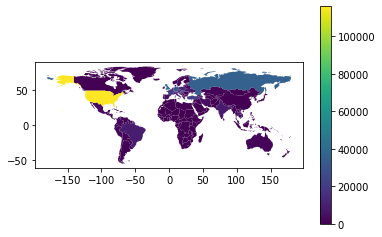

In [5]:
countries.plot('New_cases', legend=True)

### changing to an Equal Earth crs

Converting the geospatial data to a new coordinate reference system is as easy as using the `to_crs`

R equivalent
```r
sf_df <- sf::st_transform(sf_df, {epsg_code})
```

In [6]:
countries = countries.to_crs(epsg=8857)

<AxesSubplot:>

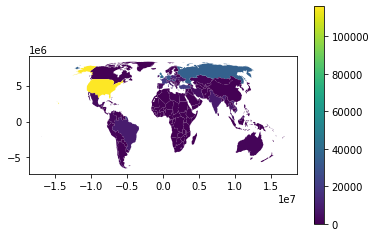

In [7]:
countries.plot('New_cases',  legend=True)

## Raster data

Now I will show you a quick look at some Raster data in Python using rioxarray

In [8]:
import rioxarray as riox

In [9]:
ds = riox.open_rasterio('data/mystery_dem.tif')

### What we have created
what we have made, is an Xarray dataarray that is holding our Raster data. It has
X coordinates and y coordinates in the geospatial coordinate system associated with the raster, as well as a grid of the values for each "band". This example is a Digital Elevation model.

In [10]:
ds

<xarray.DataArray (band: 1, y: 2152, x: 3983)>
[8571416 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 144.8 144.8 144.8 144.8 ... 148.1 148.1 148.1 148.1
  * y            (y) float64 -36.07 -36.07 -36.07 ... -37.86 -37.86 -37.86
    spatial_ref  int64 0
Attributes:
    _FillValue:    -32768.0
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     dem3s_int

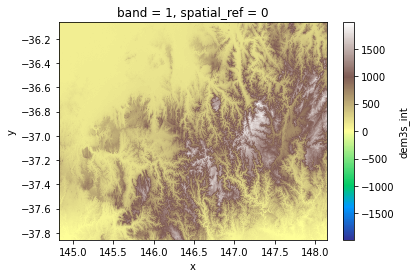

In [11]:
ds.plot(cmap='terrain')

As you see below, we basically have a numpy 2D array of values nested in a coordinate system

In [12]:
ds.values

array([[[ 96,  96,  96, ..., 685, 686, 694],
        [ 96,  96,  96, ..., 692, 686, 685],
        [ 96,  96,  96, ..., 679, 665, 663],
        ...,
        [  4,   5,   5, ...,   0,   0,   0],
        [  4,   5,   6, ...,   0,   0,   0],
        [  5,   5,   5, ...,   0,   0,   0]]], dtype=int16)

In [13]:
ds.values.shape

(1, 2152, 3983)

With rioxarray, your xarray data has access to geospatial commands as well

In [15]:
ds.rio.crs

CRS.from_epsg(4326)

In [18]:
from rasterio.enums import Resampling

ds_utm = ds.rio.reproject('EPSG:32755', resampling=Resampling.bilinear)

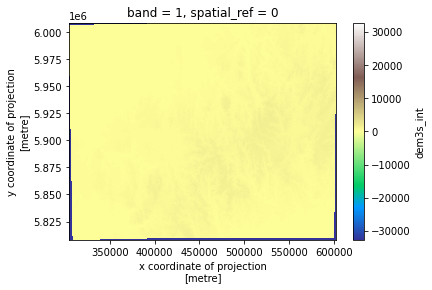

In [20]:
ds_utm.plot(cmap='terrain')

-30000 elevation? looks like we have an issue with no data, lets get rid of the no datas with the `where` method and some logic

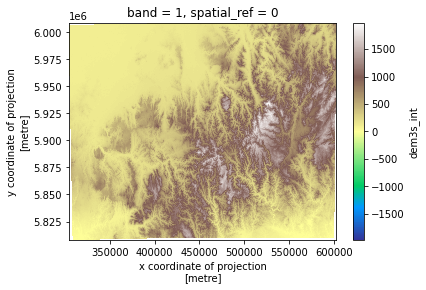

In [21]:
ds_no_nans = ds_utm.where(ds_utm!=ds_utm.rio.nodata) 

ds_no_nans.plot(cmap='terrain')

data is 3 second Digital Elevation data from Geoscience Australia [link](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/69888)

### R equivalent

```R
library('raster')
ras <- raster::raster({path to raster dataset})


plot(ras) # plotting raster data

# reprojecting
newproj <- "+proj=lcc +lat_1=48 +lat_2=33 +lon_0=-100 +datum=WGS84"
proj_raster <- raster::projectRaster(ras, newproj, method='bilinear')

```